In [1]:
import os
import json


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

import keras
import tensorflow as tf


Populating the interactive namespace from numpy and matplotlib


/home/connor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [78]:
from importlib import reload

In [79]:
import training_utils
reload(training_utils)

<module 'training_utils' from '/home/connor/iMaterialist_Challenge/training_utils.py'>

In [4]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence

from keras.applications import InceptionV3,inception_v3
from keras.applications import VGG16, vgg16
from sklearn.metrics import f1_score

In [5]:
labels = json.load(open('data/reformatted_train.json'))


In [6]:
y = [labels[str(x)]['labelId'] for x in range(1,10000)]
y = [[int(x) for x in a] for a in y]
largest = 0
for l in y:
    for num in l:
        if num > largest:
            largest = num
NUM_CLASSES = largest
print(largest)

228


In [115]:
# "first stupid model" this is basically just the pretrained convolutional layers with a 1000 unit 
# fully connected layer before the dense output layer. The output layer is a sigmoid rather than a softmax as the 
# problem is a multi-label multi-class problem

def create_model(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(5000, activation = 'relu', name = 'dense1')(X)
    X = Dense(5000, activation = 'relu', name = 'dense2')(X)
    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [133]:
def create_finetuned_vgg16(base_layers):
    for i, layer in enumerate(base_layers.layers):
        if i not in [15,16,17]:
            layer.trainable = True
        else:
            layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(5000, activation = 'relu', name = 'dense1')(X)
    X = Dense(5000, activation = 'relu', name = 'dense2')(X)
    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [8]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
iv3model = create_model(inception_base)

In [10]:
sgd = keras.optimizers.SGD(lr = .01, decay = .00001)
#rmsprop = keras.optimizers.RMSprop(lr = .01, decay = .00001)
#adam = keras.optimizers.Adam(lr = .001, decay = .00001)

In [117]:
#training_gen = data_gen.flow(X_train,y_train,seed = 42)
training_gen,Xval,yval = training_utils.create_sequence_and_val(labels,5000,200,inception_v3.preprocess_input)

In [118]:
iv3model.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])

In [51]:
X, y = training_gen.__getitem__(5)

In [52]:
X.shape

(10, 224, 224, 3)

In [119]:
iv3model.fit_generator(training_gen,
                     epochs = 10,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)

Epoch 1/10
100/100 [==============================] - 181s 2s/step - loss: 0.0853 - acc: 0.9773 - val_loss: 0.1015 - val_acc: 0.9773
Epoch 2/10
100/100 [==============================] - 173s 2s/step - loss: 0.0854 - acc: 0.9772 - val_loss: 0.1011 - val_acc: 0.9774
Epoch 3/10
100/100 [==============================] - 174s 2s/step - loss: 0.0852 - acc: 0.9772 - val_loss: 0.1009 - val_acc: 0.9774
Epoch 4/10
100/100 [==============================] - 174s 2s/step - loss: 0.0849 - acc: 0.9773 - val_loss: 0.1007 - val_acc: 0.9775
Epoch 5/10
100/100 [==============================] - 174s 2s/step - loss: 0.0846 - acc: 0.9773 - val_loss: 0.1005 - val_acc: 0.9775
Epoch 6/10
100/100 [==============================] - 177s 2s/step - loss: 0.0846 - acc: 0.9773 - val_loss: 0.1002 - val_acc: 0.9776
Epoch 7/10
100/100 [==============================] - 174s 2s/step - loss: 0.0845 - acc: 0.9773 - val_loss: 0.1000 - val_acc: 0.9776
Epoch 8/10
100/100 [==============================] - 174s 2s/step - 

In [131]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vggmodel = create_finetuned_vgg16(vgg_base)
sgd = keras.optimizers.SGD(lr = .01)

In [137]:
training_gen2,Xval2,yval2 = training_utils.create_sequence_and_val(labels,5000,100,vgg16.preprocess_input)

In [138]:
vggmodel.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])

In [140]:
vggmodel.fit_generator(training_gen2,
                     epochs = 5,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers =6,
                     use_multiprocessing = True,
                     verbose = 1)

Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[100,3,224,224]
	 [[Node: block1_conv1_2/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_4_0/_7107, block1_conv1_2/kernel/read)]]
	 [[Node: loss_14/mul/_7143 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_772_loss_14/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'block1_conv1_2/convolution', defined at:
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-131-c5be1ca54bf0>", line 1, in <module>
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py", line 116, in VGG16
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,3,224,224]
	 [[Node: block1_conv1_2/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_4_0/_7107, block1_conv1_2/kernel/read)]]
	 [[Node: loss_14/mul/_7143 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_772_loss_14/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [139]:
for i,layer in enumerate(vggmodel.layers):
    print(i,layer,layer.trainable)

0 <keras.engine.topology.InputLayer object at 0x7f1ae1562080> False
1 <keras.layers.convolutional.Conv2D object at 0x7f1ae1562a90> False
2 <keras.layers.convolutional.Conv2D object at 0x7f1ae1562b70> False
3 <keras.layers.pooling.MaxPooling2D object at 0x7f1ae1487518> False
4 <keras.layers.convolutional.Conv2D object at 0x7f1ae14a5710> False
5 <keras.layers.convolutional.Conv2D object at 0x7f1ae14a5048> False
6 <keras.layers.pooling.MaxPooling2D object at 0x7f1ae144c588> False
7 <keras.layers.convolutional.Conv2D object at 0x7f1ae1471908> False
8 <keras.layers.convolutional.Conv2D object at 0x7f1ae1471fd0> False
9 <keras.layers.convolutional.Conv2D object at 0x7f1ae14182b0> False
10 <keras.layers.pooling.MaxPooling2D object at 0x7f1ae13bcf60> False
11 <keras.layers.convolutional.Conv2D object at 0x7f1ae13ceba8> False
12 <keras.layers.convolutional.Conv2D object at 0x7f1ae13e1e48> False
13 <keras.layers.convolutional.Conv2D object at 0x7f1ae13f24e0> False
14 <keras.layers.pooling.MaxPoo

In [88]:
preds = iv3model.predict(Xval)

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


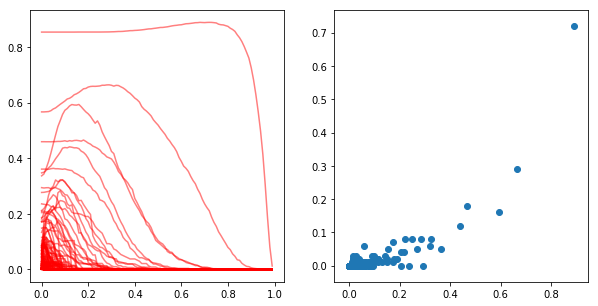

In [112]:
def find_best_f1(true_col,pred_col,ax):
    
    f1s = []
    thresholds = np.linspace(0,1,100,endpoint=False)
    for t in thresholds:
        col_hat = pred_col > t
        f1 = f1_score(true_col.flatten(),col_hat.flatten())
        f1s.append(f1)
    ax.plot(thresholds,f1s,alpha = .5,color = 'r')
    #print(f1s)
    if np.all(f1s == 0.0):
        return .1, None
    else:
        best = np.argmax(f1s)
        #print(thresholds[best], f1s[best])
        return thresholds[best], f1s[best]

optimal_ts = np.zeros((preds.shape))
fig,ax = plt.subplots(1,2, figsize = (10,5))
fs, ts = [], []
for c in range(0,preds.shape[1]):
    t,f = find_best_f1(yval[:,c],preds[:,c],ax[0])
    fs.append(f)
    ts.append(t)
    optimal_ts[:,c] = t
ax[1].scatter(fs,ts)
plt.show()

In [113]:
y_hat = np.zeros(preds.shape)
for c in range(0,preds.shape[1]):
    t = optimal_ts[0,c] 
    y_hat[:,c] = preds[:,c] > t
    #print("{}   {}   {}".format(c,t,f1_score(yval[:,c],y_hat[:,c])))
f1 = f1_score(yval,y_hat,average = 'micro')
print(f1)

0.04513385543569084


In [101]:
y_hat = preds > .15    
f1 = f1_score(yval,y_hat,average = 'micro')
print(f1)

0.3735322119961917


In [91]:
f1_score(yval[:,10],preds[:,10]> .06)

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [60]:
def eval_model(model,Xval,yval):
    preds = model.predict(Xval)
    thresholds = np.linspace(0,1,100,endpoint=False)
    f1s = []
    for t in thresholds:
        y_hat = preds > t
        f1 = f1_score(yval,y_hat,average = 'micro')
        f1s.append(f1)
    plotf1s(thresholds,f1s)

In [64]:
def plotf1s(thresholds,f1s):
    fig, ax = plt.subplots()
    ax.plot(thresholds,f1s)
    best = np.argmax(f1s)
    ax.set_title("F1 score \n best thresh: {}, score:{}".format(thresholds[best],f1s[best]))
    plt.show()

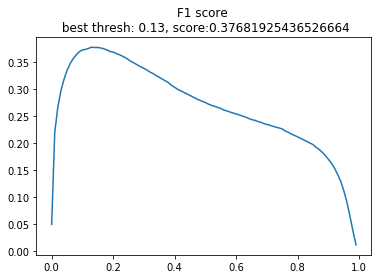

In [120]:
eval_model(iv3model,Xval,yval)

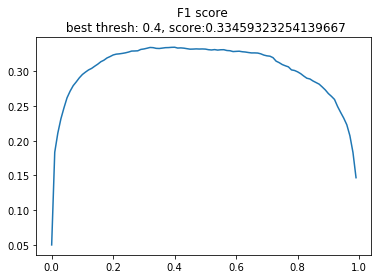

In [77]:
eval_model(vggmodel,Xval,yval)